### Parameters

In [1]:
chain_length = 4

Ω = 2.5

omit_ratio = 0

In [2]:
import numpy as np

num_layers = 2
periods = 1
num_time_steps = 150
dt = periods / num_time_steps * 2*np.pi/Ω
A = 0

In [3]:
from qiskit.circuit import ParameterVector, Parameter

cost_threshold = 1e-3

parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers
param_space = ParameterVector('θ', parameter_space_size)

parameter_space_size2 = 2 * chain_length * num_layers + (omit_ratio*chain_length)//2 + (((chain_length*(1-omit_ratio)))//2-1)
param_space2 = ParameterVector('θ', parameter_space_size2)

### Functions

#### QFT and QFT$^\dagger$

In [4]:
#QFT Circuit
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

#Inverse Quantum Fourier Transform
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    return qc

#### Ansatz creator for spin chain

In [5]:
def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    param_counter = -1
    def ansatz_circuit_0(qc, param_space, param_counter=0):
        print('Number of params:',parameter_space_size)
        # layer 0
        # param_counter=0
        for i in range(qc.num_qubits):
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    def ansatz_circuit_1(qc, param_space, param_counter=0):
        # param_counter = 2 * chain_length
        for i in range(qc.num_qubits-1):
            qc.cx(i,i+1)
        qc.cx(-1,0)
        for i in range(qc.num_qubits):
            qc.rz(param_space[param_counter:=param_counter+1],i)
            qc.rx(param_space[param_counter:=param_counter+1],i)
            qc.rz(param_space[param_counter:=param_counter+1],i)
        return param_counter
    param_counter = ansatz_circuit_0(qc, param_space, param_counter)
    for i in range(num_layers):
        param_counter = ansatz_circuit_1(qc, param_space, param_counter)
    display(qc.draw('mpl'))

#### Ansatz creator for spin ladder

In [6]:
def ansatz_circuit_ladder(qc, param_space=param_space2, omit_ratio=omit_ratio):
    counter = -1
    def layer(qc, params, param_counter):
        for i in range(qc.num_qubits):
            qc.rx(params[param_counter:=param_counter+1],i)
            qc.rz(params[param_counter:=param_counter+1],i)
        return param_counter
    def entangle(qc, params, param_counter, double_entangle):
        for i in range(qc.num_qubits//2):
            qc.rzz(params[param_counter:=param_counter+1], 2*i, 2*i+1)
        if double_entangle:
            for i in range((qc.num_qubits-1)//2):
                qc.rzz(params[param_counter:=param_counter+1], 2*i+1, 2*i+2)
        return param_counter
    fra = Fraction(omit_ratio).limit_denominator()
    # print(fra)
    for layer_count in range(num_layers):
        counter = layer(qc, param_space, counter)
        counter = entangle(qc, param_space, counter, double_entangle=(layer_count%fra.denominator<fra.numerator))
        qc.barrier()
    display(qc.draw('mpl'))

#### Hamiltonians

In [7]:
def hamiltonian(t, A=2, J=1, Ω=Ω):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append([''.join(op), -J/4])
    for i in range(chain_length):
        op1, op2 = creator[:], creator[:]
        op1[i] = 'X'
        op2[i] = 'Y'
        ham.append([''.join(op1), A * np.cos(Ω*t)])
        ham.append([''.join(op2), A * np.sin(Ω*t)])
    ham = np.array(ham)
    # print(A * np.cos(Ω*t))
    return SparsePauliOp(ham[:,0], ham[:,1])

def hamiltonian_linear(t, A, Δ=1, Ω=Ω):
    ham = SparsePauliOp(['Z','X'] , [-Δ/2, A/2/Ω*np.cos(Ω*t)])
    # plt.plot(t, A*np.cos(Ω*t)/2,'.')
    return ham

#### Unitary time evolution

In [8]:
def unitary_time_evolver(ham, *args, num_qbits=chain_length, time=num_time_steps*dt, dt=dt):#num_steps=num_time_steps):

    circuit = QuantumCircuit(num_qbits)
    
    for i in range(1, int(time/dt)+1):
        circuit.compose(HamiltonianGate(ham(i*dt, *args), time=dt), inplace=True)
    
    return circuit

### From qiskit docs

First, we'll setup a function that calculates the state fidelity -- a percentage of overlap between two states that we'll use as a penalty for VQD:

wtf is this

In [9]:
def calculate_overlap(circuits_1, circuits_2, parameters, backend):

    def get_global_fidelity(probability_distribution):
        """Process the probability distribution of a measurement to determine the
        global fidelity.
        """
        return probability_distribution.get(0, 0)
    
    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    
    def construct_fidelity_circuits(circuits_1, circuits_2):
        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
        circuits = []
        for (circuit_1, circuit_2) in zip(circuits_1, circuits_2):
            # re-parametrize input circuits
            parameters_1 = ParameterVector("x", circuit_1.num_parameters)
            parametrized_circuit_1 = circuit_1.assign_parameters(parameters_1)
            parameters_2 = ParameterVector("y", circuit_2.num_parameters)
            parametrized_circuit_2 = circuit_2.assign_parameters(parameters_2)

            circuit = create_fidelity_circuit(
                parametrized_circuit_1, parametrized_circuit_2
            )
            circuits.append(circuit)

        return circuits

    circuits = construct_fidelity_circuits(circuits_1, circuits_2)

    job = backend.run(circuits=circuits, parameter_values=parameters)
    result = job.result()

    raw_fidelities = [
        get_global_fidelity(prob_dist) for prob_dist in result.quasi_dists
    ]

    return np.clip(raw_fidelities, 0, 1).tolist()

Next, we'll setup our runtime primitives

In [10]:
from qiskit.primitives import Estimator
from qiskit.primitives import Sampler

sampler = Sampler()
estimator = Estimator()

It's time to write VQD's cost function:

#### Cost function

In [11]:
import numpy as np

def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):
    
    if len(parameters.shape) == 1:
        parameters = np.reshape(parameters, (-1, ansatz.num_parameters))

    batch_size = len(parameters)

    estimator_job = estimator.run(
        batch_size * [ansatz], batch_size * [hamiltonian], parameters
    )

    total_cost = np.zeros(batch_size)

    if step > 1:
        # compute overlap cost
        batched_prev_states = [state for state in prev_states for _ in range(batch_size)]
        costs = calculate_overlap(
            batch_size * [ansatz] * (step - 1),
            batched_prev_states,
            np.tile(parameters, (step - 1, 1)),
            sampler
        )

        costs = np.reshape(costs, (step - 1, -1))
        for state, cost in enumerate(costs):
            total_cost -= np.real(betas[state] * cost)

    estimator_result = estimator_job.result()

    values = estimator_result.values + total_cost
    
    return ((values if len(values) > 1 else values[0])-1)**2

### Linear Driver code

In [12]:
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
from qiskit import QuantumCircuit
from qiskit.circuit.library import HamiltonianGate, UGate
from scipy.optimize import minimize

k = 2**1
betas = [5]*k
x0 = np.zeros(3)

A_Array = np.linspace(0,4/Ω,8)

time_evo_circuits = [unitary_time_evolver(hamiltonian_linear, i, num_qbits=1) for i in A_Array]

matrix = np.array([[1,0],[0,0]])
# observable = Pauli(['I','Z'],[.5,.5])
observable = SparsePauliOp.from_operator(matrix)
# print(observable)
ground_states = []
excited_states = [] 

for r in time_evo_circuits:

    ansatz = QuantumCircuit(1)
    theta = ParameterVector('θ',3)
    ansatz.u(*theta,0)
    ansatz.compose(r, inplace=True)
    ansatz.compose(UGate(*theta).inverse(),inplace=True)
    # display(ansatz.draw())
    
    prev_states = []
    prev_opt_parameters = []
    eigenvalues = []


# try:
    for step in range(1, k + 1):
        
        if step > 1:
            prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
        
        result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable), method="BFGS")
        # print(result)
    
        prev_opt_parameters = result.x
        eigenvalues.append(result.fun)
    
    eigenvalues = np.array(eigenvalues)
    ground_states.append(eigenvalues[0]/Ω)
    excited_states.append(eigenvalues[1]/Ω)

# except Exception as e:
#     print(e)

#### Plotter

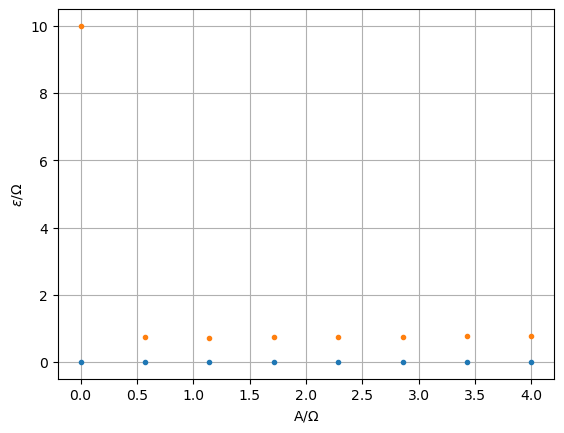

In [13]:
import matplotlib.pyplot as plt
plt.plot(A_array*Ω, ground_states,'.')
plt.plot(A_array*Ω, excited_states,'.')
plt.grid()
plt.xlabel('A/$\\Omega$')
plt.ylabel('$\\epsilon/\\Omega$')
plt.show()